In [ ]:
!pip install medmnist

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

# Set seed and device
seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sampling real data
def sample_real_data(n=512, mode="sine"):
    """
    Sample real 2D data for training the GAN.

    Args:
        n (int): Number of samples to generate.
        mode (str): Either 'sine' or 'noisy'. Determines the function used to generate y-values.

    Returns:
        torch.Tensor: Tensor of shape (n, 2), where each row is (x, y).
    """
    x = np.random.uniform(-4, 4, size=(n, 1))
    if mode == "sine":
        y = np.sin(x)
    elif mode == "noisy":
        y = np.sin(2 * x) + 0.3 * np.cos(5 * x) + np.random.normal(0, 0.1, size=(n, 1))
    return torch.tensor(np.hstack((x, y)), dtype=torch.float32)

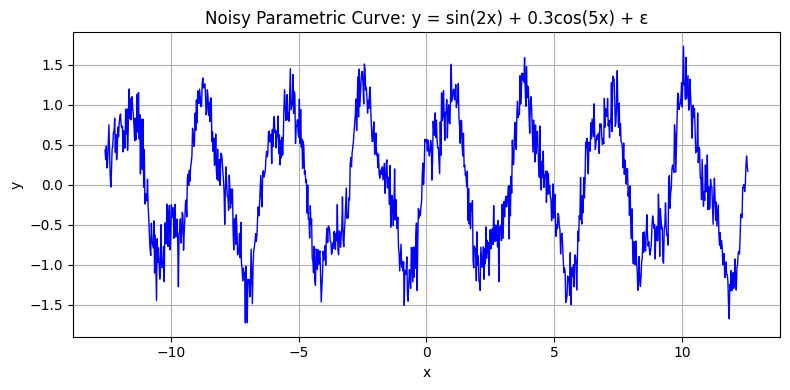

In [15]:
#  Plot the real noisy parametric curve for report
x_curve = np.linspace(-4 * np.pi, 4 * np.pi, 1000)
epsilon = np.random.normal(0, 0.2, x_curve.shape)
y_curve = np.sin(2 * x_curve) + 0.3 * np.cos(5 * x_curve) + epsilon

plt.figure(figsize=(8, 4))
plt.plot(x_curve, y_curve, color='blue', linewidth=1)
plt.title("Noisy Parametric Curve: y = sin(2x) + 0.3cos(5x) + ε")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Generator and Discriminator
class Generator(nn.Module):
    """Generator model for 2D data. Takes random noise as input and generates (x, y) coordinates."""
    def __init__(self, input_dim=2, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2),
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    """Discriminator model for 2D data. Outputs a probability score for real/fake."""
    def __init__(self, input_dim=2, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# GAN training function
def train_gan(mode="sine", epochs=2000):
    """
    Trains a GAN on 2D sine or noisy curve data.

    Args:
        mode (str): The type of real data to train on ('sine' or 'noisy').
        epochs (int): Number of training iterations.

    Returns:
        Generator: Trained generator model.
    """
    G = Generator().to(device)
    D = Discriminator().to(device)
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(G.parameters(), lr=0.001)
    optimizer_D = optim.Adam(D.parameters(), lr=0.001)

    for epoch in range(epochs):
        real_data = sample_real_data(512, mode).to(device)
        z = torch.randn(512, 2).to(device)
        fake_data = G(z)

        # Train Discriminator
        real_labels = torch.ones(512, 1).to(device)
        fake_labels = torch.zeros(512, 1).to(device)

        D_loss_real = criterion(D(real_data), real_labels)
        D_loss_fake = criterion(D(fake_data.detach()), fake_labels)
        D_loss = D_loss_real + D_loss_fake
        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        # Train Generator
        G_loss = criterion(D(fake_data), real_labels)
        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

        if (epoch+1) % 1000 == 0:
            print(f"[{mode.upper()}] Epoch {epoch+1}/{epochs} | D_loss: {D_loss.item():.4f} | G_loss: {G_loss.item():.4f}")

    return G

[SINE] Epoch 1000/2000 | D_loss: 1.4390 | G_loss: 0.6991
[SINE] Epoch 2000/2000 | D_loss: 1.3102 | G_loss: 0.8030


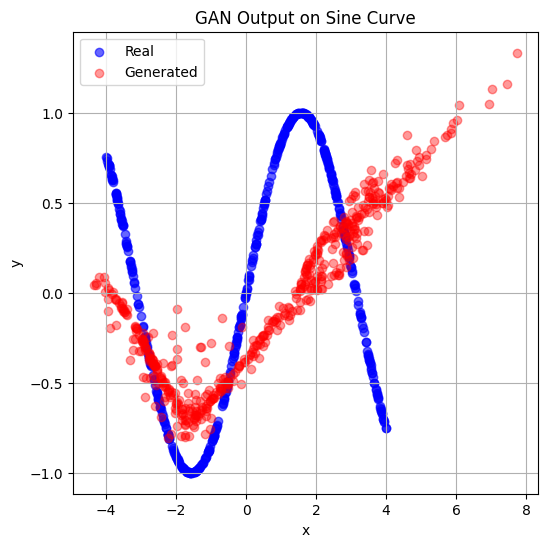

[NOISY] Epoch 1000/2000 | D_loss: 1.1866 | G_loss: 0.8387
[NOISY] Epoch 2000/2000 | D_loss: 1.4098 | G_loss: 0.9194


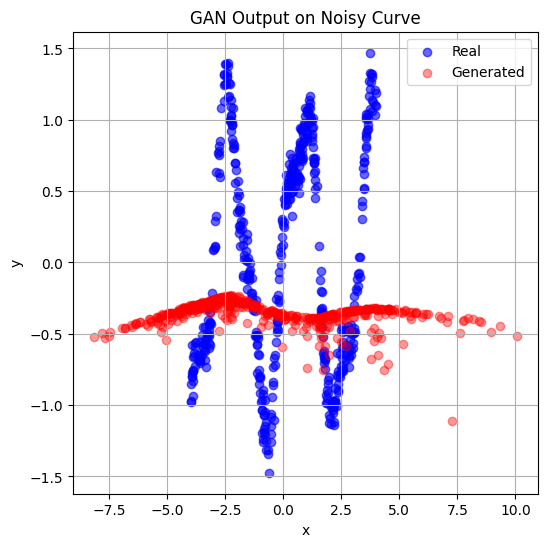

In [ ]:
# Plotting function
def plot_generated_data(G, mode="sine"):
    """
    Plots both real and generated 2D data points.

    Args:
        G (Generator): Trained generator model.
        mode (str): The type of real data to use for comparison ('sine' or 'noisy').
    """
    real = sample_real_data(512, mode)
    fake = G(torch.randn(512, 2).to(device)).detach().cpu()
    plt.figure(figsize=(6, 6))
    plt.scatter(real[:, 0], real[:, 1], color='blue', alpha=0.6, label='Real')
    plt.scatter(fake[:, 0], fake[:, 1], color='red', alpha=0.4, label='Generated')
    plt.legend()
    plt.title(f"GAN Output on {mode.title()} Curve")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()

# Run Task 1 and 2
G_sine = train_gan("sine")
plot_generated_data(G_sine, "sine")
G_noisy = train_gan("noisy")
plot_generated_data(G_noisy, "noisy")

In [17]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from medmnist import INFO, PathMNIST
import matplotlib.pyplot as plt
import numpy as np

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and prepare PathMNIST dataset
def load_pathmnist_dataset():
    """
    Loads the PathMNIST dataset and returns both the raw dataset and a DataLoader.

    Returns:
        dataset: Raw PathMNIST training dataset.
        DataLoader: DataLoader object for the dataset.
    """
    info = INFO["pathmnist"]
    DataClass = getattr(__import__('medmnist'), info["python_class"])
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5]*3, std=[.5]*3)
    ])
    dataset = DataClass(split='train', transform=transform, download=True)
    return dataset, DataLoader(dataset, batch_size=64, shuffle=True)

train_dataset, train_loader = load_pathmnist_dataset()


In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(dataset):
    """
    Plot histogram showing number of images per class in PathMNIST.
    Converts one-hot encoded labels to scalar class indices.
    """
    labels = []

    for i in range(len(dataset)):
        label = dataset[i][1]
        # Convert torch.Tensor to NumPy array
        if isinstance(label, torch.Tensor):
            label = label.numpy()
        # Convert one-hot encoded vector to class index
        if isinstance(label, (np.ndarray, list)) and len(label) > 1:
            label = int(np.argmax(label))
        labels.append(label)

    # Convert final list to flat NumPy array
    labels = np.array(labels)

    # Plot histogram
    plt.figure(figsize=(6, 4))
    plt.hist(labels, bins=np.arange(10) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')
    plt.xticks(range(9))
    plt.xlabel("Pathology Class Label")
    plt.ylabel("Number of Images")
    plt.title("PathMNIST Class Distribution")
    plt.grid(True)
    plt.show()
    return labels



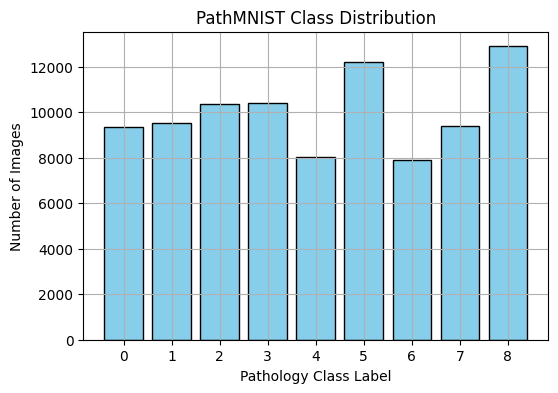

array([[0],
       [4],
       [7],
       ...,
       [2],
       [0],
       [2]])

In [24]:
plot_class_distribution(train_dataset)


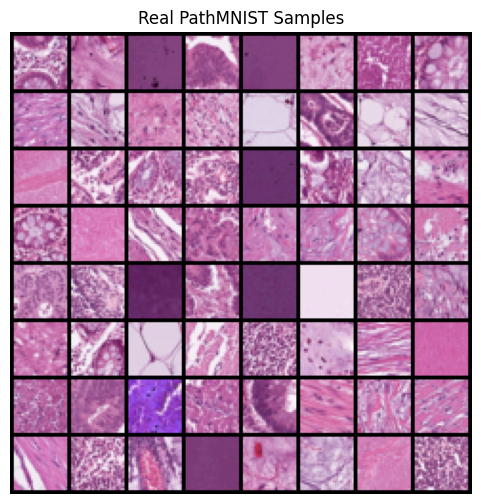

In [26]:
#Display Real Images
def show_real_images():
    """
    Displays a grid of real images from the PathMNIST dataset.
    """
    imgs, _ = next(iter(train_loader))
    grid = torchvision.utils.make_grid(imgs[:64], nrow=8, normalize=True).permute(1, 2, 0)
    plt.figure(figsize=(6, 6))
    plt.imshow(grid.cpu())
    plt.title("Real PathMNIST Samples")
    plt.axis("off")
    plt.show()

show_real_images()


In [27]:
#DCGAN Generator & Discriminator
class GeneratorDCGAN(nn.Module):
    """DCGAN-style Generator for 28x28x3 images."""
    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 128, 7, 1, 0),
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)


class DiscriminatorDCGAN(nn.Module):
    """DCGAN-style Discriminator for 28x28x3 images."""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [28]:
#Train DCGAN
def train_dcgan(epochs=20, z_dim=100):
    """
    Trains a DCGAN on the PathMNIST dataset.
    """
    G = GeneratorDCGAN(z_dim).to(device)
    D = DiscriminatorDCGAN().to(device)

    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

    fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

    for epoch in range(epochs):
        for imgs, _ in train_loader:
            real_imgs = imgs.to(device)
            batch_size = real_imgs.size(0)

            z = torch.randn(batch_size, z_dim, 1, 1, device=device)
            fake_imgs = G(z)

            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            # Train Discriminator
            D_loss_real = criterion(D(real_imgs), real_labels)
            D_loss_fake = criterion(D(fake_imgs.detach()), fake_labels)
            D_loss = D_loss_real + D_loss_fake
            optimizer_D.zero_grad(); D_loss.backward(); optimizer_D.step()

            # Train Generator
            G_loss = criterion(D(fake_imgs), real_labels)
            optimizer_G.zero_grad(); G_loss.backward(); optimizer_G.step()

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} | D_loss: {D_loss.item():.4f} | G_loss: {G_loss.item():.4f}")

    return G, fixed_noise

In [29]:
#Display Generated Images
def show_generated_images(G, fixed_noise):
    """
    Displays a grid of generated images using a fixed noise vector.
    """
    G.eval()
    with torch.no_grad():
        fake_imgs = G(fixed_noise).detach().cpu()
    grid = torchvision.utils.make_grid(fake_imgs, nrow=8, normalize=True).permute(1, 2, 0)
    plt.figure(figsize=(6, 6))
    plt.imshow(grid)
    plt.title("Generated PathMNIST Images")
    plt.axis("off")
    plt.show()


Epoch 1/20 | D_loss: 0.9580 | G_loss: 2.0318
Epoch 5/20 | D_loss: 1.0971 | G_loss: 1.2661
Epoch 10/20 | D_loss: 0.5553 | G_loss: 3.1309
Epoch 15/20 | D_loss: 1.7616 | G_loss: 1.0437
Epoch 20/20 | D_loss: 1.7042 | G_loss: 6.6668


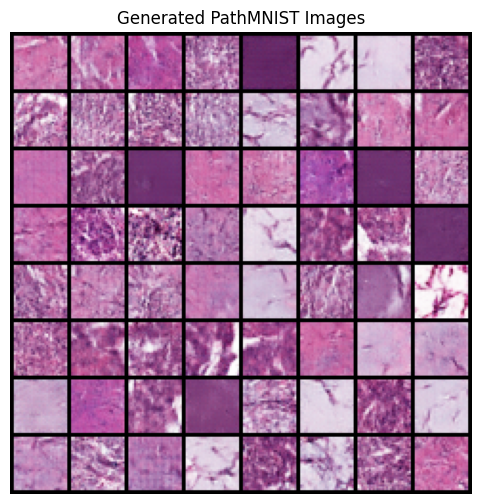

In [30]:
# Run training and show outputs
G_dcgan, fixed_noise = train_dcgan(epochs=20)
show_generated_images(G_dcgan, fixed_noise)


In [ ]:
# Load PathMNIST dataset
info = INFO['pathmnist']
DataClass = getattr(__import__('medmnist'), info['python_class'])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5]*3, std=[.5]*3)
])

train_data = DataClass(split='train', transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
num_classes = len(info['label'])  # Should be 9 for PathMNIST


In [ ]:
class Generator(nn.Module):
    """Standard DCGAN generator."""
    def __init__(self, z_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 128, 7, 1, 0),
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

class cGenerator(nn.Module):
    """Conditional Generator that adds label embedding to noise vector."""
    def __init__(self, z_dim, num_classes):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, z_dim)
        self.gen = Generator(z_dim)

    def forward(self, z, labels):
        c = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        z = z + c
        return self.gen(z)


In [ ]:
class cDiscriminator(nn.Module):
    """
    Conditional Discriminator that embeds class labels and evaluates
    image-label pairs for authenticity.
    """
    def __init__(self, num_classes):
        super().__init__()
        self.label_embed = nn.Embedding(num_classes, 3 * 28 * 28)
        self.disc = Discriminator(in_channels=6)

    def forward(self, img, labels):
        label = self.label_embed(labels).view(-1, 3, 28, 28)
        x = torch.cat([img, label], dim=1)
        return self.disc(x)


In [ ]:
class Discriminator(nn.Module):
    """Generalized Discriminator that accepts a variable number of input channels."""
    def __init__(self, in_channels=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128*7*7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


[cGAN] Epoch 1/10 | D Loss: 2.1074 | G Loss: 0.3869


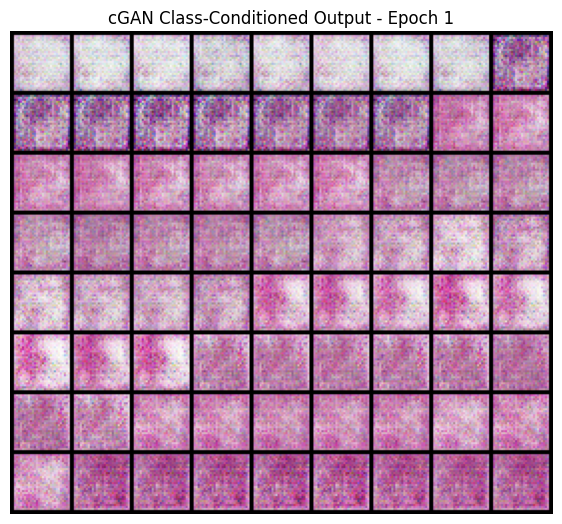

[cGAN] Epoch 2/10 | D Loss: 1.3634 | G Loss: 1.2748


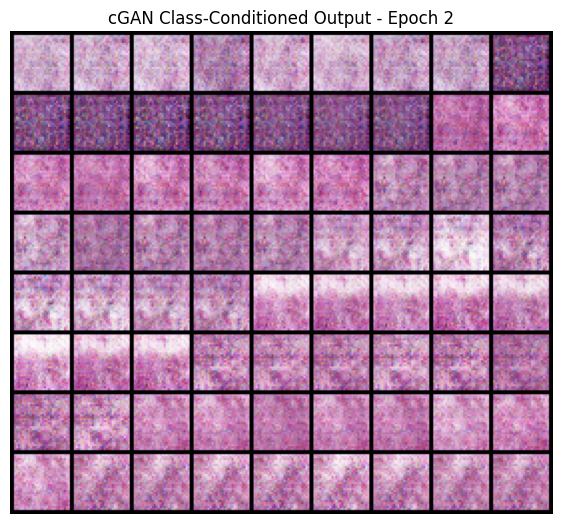

[cGAN] Epoch 3/10 | D Loss: 1.9566 | G Loss: 0.2382


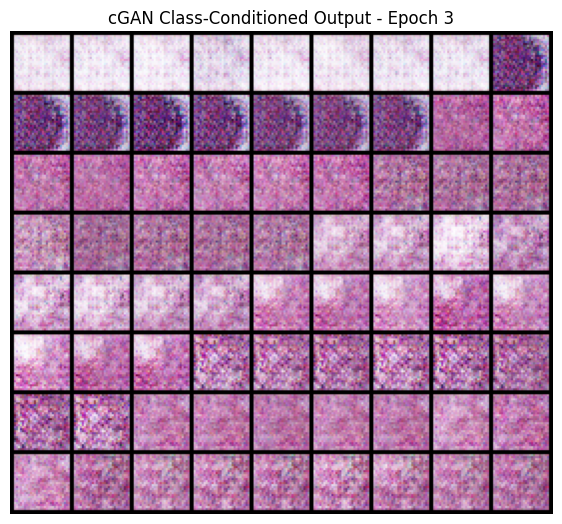

[cGAN] Epoch 4/10 | D Loss: 0.3012 | G Loss: 3.0389


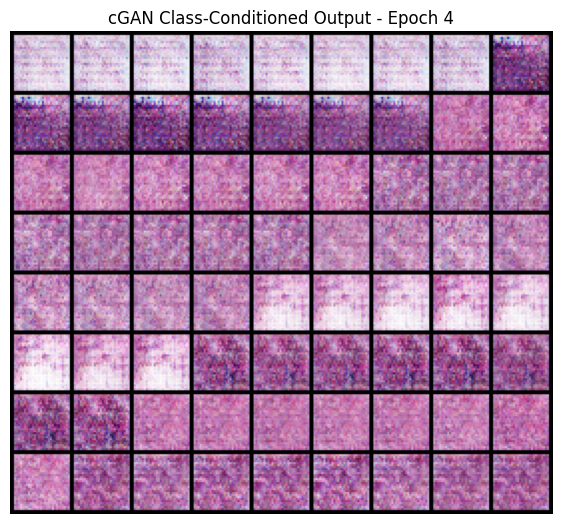

[cGAN] Epoch 5/10 | D Loss: 0.8167 | G Loss: 1.3342


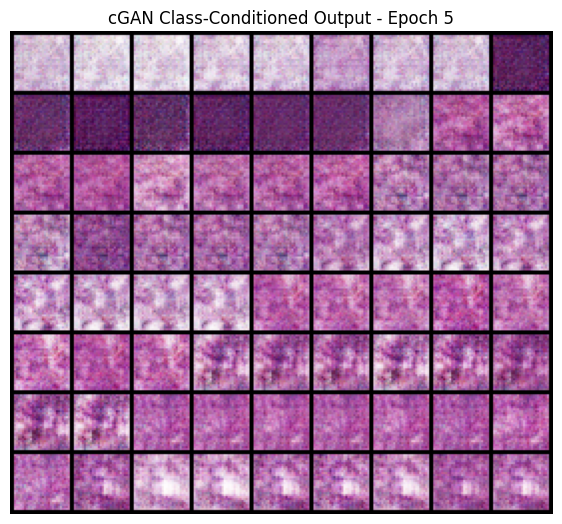

[cGAN] Epoch 6/10 | D Loss: 1.7177 | G Loss: 0.4883


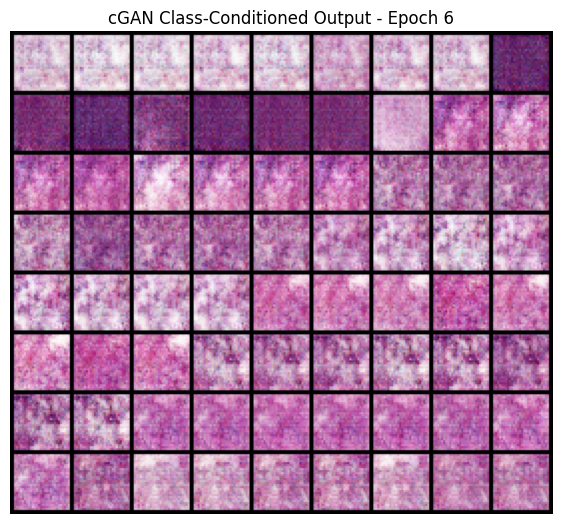

[cGAN] Epoch 7/10 | D Loss: 1.6889 | G Loss: 1.0833


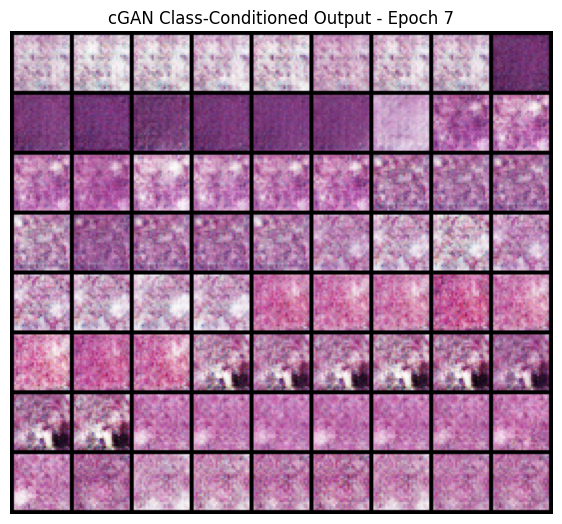

[cGAN] Epoch 8/10 | D Loss: 1.2732 | G Loss: 1.0245


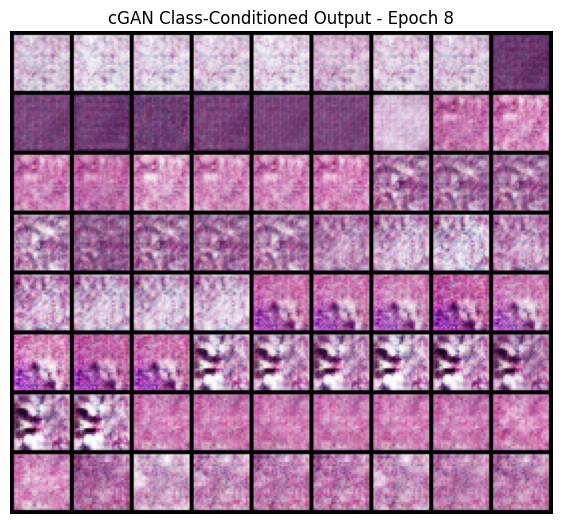

[cGAN] Epoch 9/10 | D Loss: 0.9425 | G Loss: 1.1165


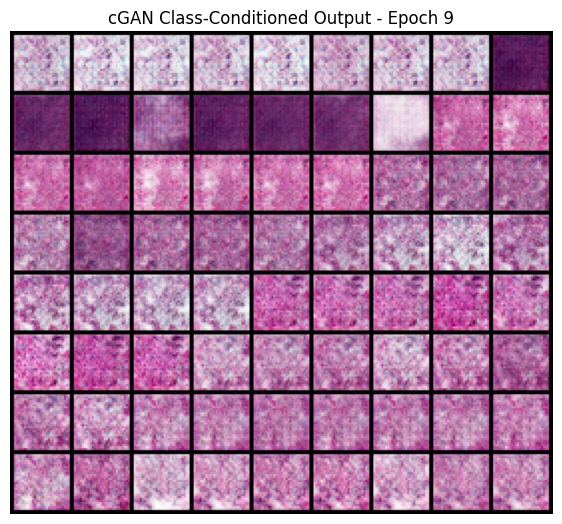

[cGAN] Epoch 10/10 | D Loss: 1.5301 | G Loss: 1.0363


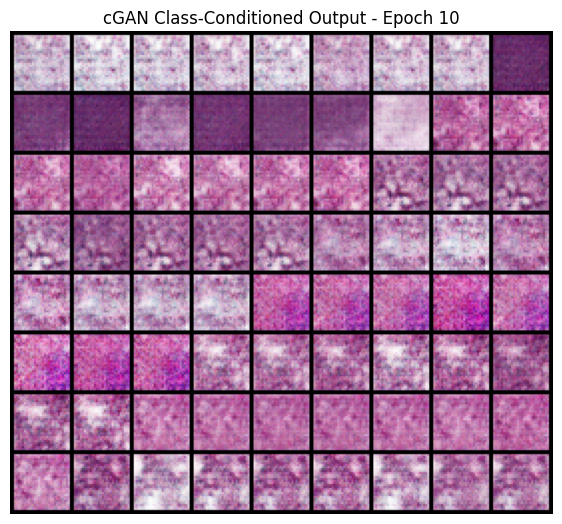

In [ ]:
# Setup for training the conditional GAN
num_classes = 9
cG = cGenerator(z_dim, num_classes).to(device)
cD = cDiscriminator(num_classes).to(device)
opt_cG = optim.Adam(cG.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_cD = optim.Adam(cD.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Fixed noise and labels for visualizing class-conditioned generations
fixed_labels = torch.tensor([i for i in range(num_classes) for _ in range(8)], device=device)
fixed_noise = torch.randn(72, z_dim, 1, 1, device=device)

# Training loop
for epoch in range(10):
    for real_imgs, labels in train_loader:
        real_imgs = real_imgs.to(device)
        labels = labels.squeeze().to(device)
        bs = real_imgs.size(0)

        real = torch.ones(bs, 1, device=device)
        fake = torch.zeros(bs, 1, device=device)

        # Train Discriminator
        cD.zero_grad()
        z = torch.randn(bs, z_dim, 1, 1, device=device)
        fake_imgs = cG(z, labels)
        loss_real = criterion(cD(real_imgs, labels), real)
        loss_fake = criterion(cD(fake_imgs.detach(), labels), fake)
        loss_D = loss_real + loss_fake
        loss_D.backward()
        opt_cD.step()

        # Train Generator
        cG.zero_grad()
        loss_G = criterion(cD(fake_imgs, labels), real)
        loss_G.backward()
        opt_cG.step()

    print(f"[cGAN] Epoch {epoch+1}/10 | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

    # Display generated samples for each class after every epoch
    with torch.no_grad():
        samples = cG(fixed_noise, fixed_labels).detach().cpu()
        grid = torchvision.utils.make_grid(samples, nrow=9, normalize=True).permute(1, 2, 0)
        plt.figure(figsize=(7, 7))
        plt.imshow(grid)
        plt.title(f"cGAN Class-Conditioned Output - Epoch {epoch+1}")
        plt.axis("off")
        plt.show()